## Chapter 13: Multi-layer Perceptrons 

# 13.2 Fully Connected Neural Networks

In this Section we describe multi-layer perceptrons which are recursively-built generalizations of the single hidden-layer units we have seen thus far. In this description we develop multi-layer units progressively, layer by layer, beginning with single hidden-layer units first described in Section 11.1, providing algebraic, graphical, and computational perspectives on their construction. This is done to make the transition to multi-layer perceptrons easier. Afterwards we briefly touch on the biological plausibility of multi-layer perceptrons, and end this Section with an in depth description of how to efficiently implement multi-layer perceptrons in Python.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import multilayer_perceptron_library as multi
from mlrefined_libraries import math_optimization_library as optlib
basic_runner = nonlib.basic_runner
regress_plotter = nonlib.nonlinear_regression_demos
classif_plotter = nonlib.nonlinear_classification_demos
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import basic plotting mechanisms
import matplotlib.pyplot as plt
from matplotlib import gridspec

# This is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

## Single hidden-layer units

The general algebraic representation (i.e., the formula) of a general single hidden-layer unit, also called a single layer unit for short, is something we first saw in Section 11.1 and is quite simple: a linear combination of input passed through a nonlinear 'activation' function (which is often a simple elementary mathematical function). Here we will denote such units in general as

\begin{equation}
f^{(1)}\left(\mathbf{x}\right)=a\left(w^{\left(1\right)}_{0}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n}\,x_n}\right)
\end{equation}

Here $a\left(\cdot\right)$ denotes an activation function and the superscripts on  $f$ and $w_0, w_1, \ldots, w_N$ indicate they represent a single-layer function and its internal weights respectively.

Because we will want to extend the single layer idea to create deeper - multilayer - perceptrons, we will find helpful to pull apart the sequence two operations used to construct it: the linear combination of input, passed through a nonlinear activation.  We refer to this manner of writing out the function as the *recursive recipe for creating single layer perceptron units* and summarize it below.

#### Recursive rescipe for single layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$<br>

<strong>2:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\,\,\, v = w_{0}^{(1)}+{\sum_{n=1}^{N}}{w_{n}^{(1)}\,x_n}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\, a\left(v\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; <strong>output:</strong> Single layer unit $\,\, a\left(v\right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 1. </span>  Illustrating the capacity of single layer units

Below we plot four instances of a single-layer unit using $\text{tanh}$ as nonlinear activation function. These take the form 

\begin{equation}
f^{(1)}(x) = \text{tanh}\left(w_0^{(1)} + w_1^{(1)}x\right)
\end{equation}

In each instance the internal parameters have been set randomly, giving each basis function a distinct shape.  

<IPython.core.display.Javascript object>


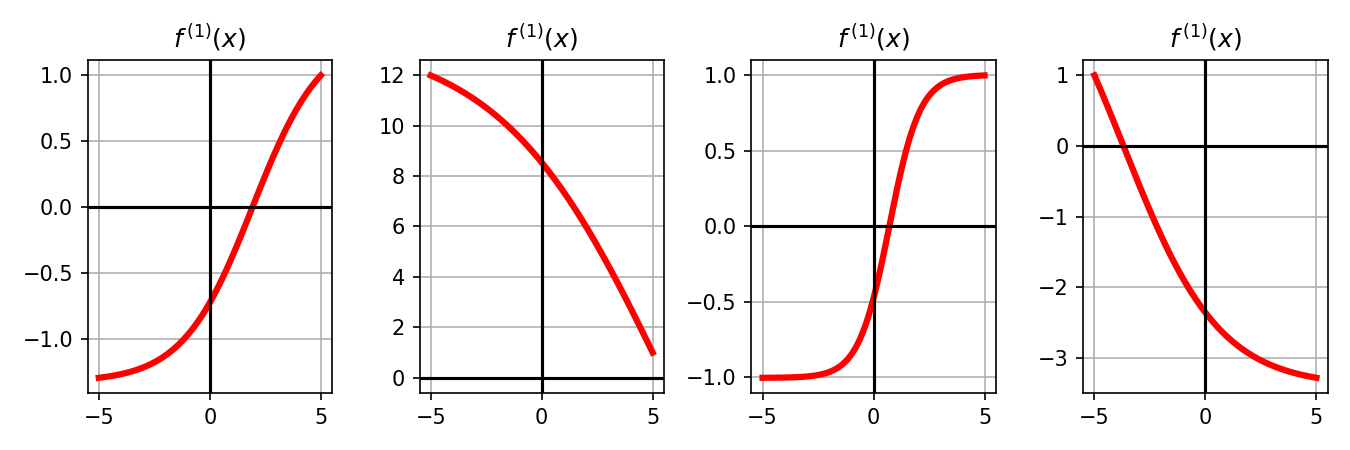

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of a single layer basis
demo.show_1d_net(num_layers = 1, activation = 'tanh')

We now repeat this experiment swapping out $\text{tanh}$ for the ReLU function, forming a single hidden layer unit with ReLU activation of the form

\begin{equation}
f^{(1)}(x) = \text{max}\left(0,w_0^{(1)} + w_1^{(1)}x\right)
\end{equation}

Once again the internal parameters of this unit allow it to take on a variety of shapes.  Below have show four instances of this ReLU single layer unit, where in each instance the unit's internal parameters are set at random.

<IPython.core.display.Javascript object>


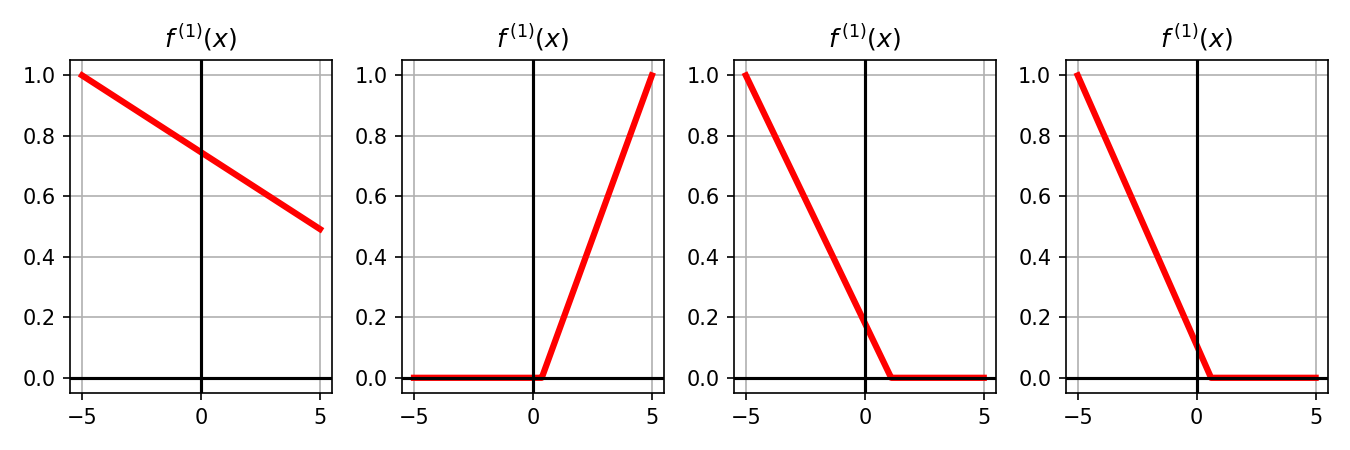

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of a single hidden layer basis
demo.show_1d_net(num_layers = 1, activation = 'relu')

---

If we form a model using $B = U_1$ such single hidden-layer units as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f^{(1)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(1)}_{U_1}\left(\mathbf{x}\right)w_{U_1}
\end{equation}

whose $j^{th}$ element takes the form $f^{(1)}_j\left(\mathbf{x}\right)=a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n}\right)$, the parameter set $\Theta$ contains not only the weights of the final linear combination $w_0$ through $w_{U_1}$, but all parameters internal to each $f_j$ as well.  This is precisely the sort of model we used in the neural network examples throughout Chapter 11.  

The top panel in the figure below shows a common graphical representation of the single layer model above, and visually unwravels the individuals operations performed by such a model depicting them visually from *left to right*.  A visual representation like this - of a model consisting of neural network units - is often referred to as a *neural network architecture* or just an *architecture*.  Here the bias and input of each single layer unit composing the model is shown as a sequence of dots all the way on the left of the diagram.  This layer - consisting of input to the system - is 'visible' to us, since this is where we inject the input of our training data (which we ourselves can 'see') and is often referred to as the *first* or *input* layer of a network.  The linear combination of input leading to each unit is then shown visually by edges connecting the input (shown as dots) to an open circle, with the nonlinear activation then shown as a larger blue circle.  In the middle of this visual depiction - where these blue circles representing all $U_1$ activations allign - is the *hidden-layer* of this network model.  This layer is called 'hidden' because it contains internally processed versions of our input that we do 'see' at the outset of learning.  Whlie the name 'hidden' while not entirely accurate - as we can visualize the internal state of these units if we so desire - it is a commonly used convention.  The output of these $U_1$ units is then collected in a linear combination, and once again visualized by edges connecting each unit to a final summation shown as an open circle.  This is the final output of the model, and is often called the final *layer* or *visible layer* of the network since we can always - regardless of how the parameters of a model are set - see what the model outputs.  Finally, in comparing the graphical and algebraic representations of a single layer model, notice that reading the graph from left to right corresponds to starting *internally* to the single layer units $f^{(1)}_j$, and working outwards to the final linear combination.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/single_layer_network.png" width="60%" height="auto"/>

<figcaption> <strong>Figure 1:</strong> <em> (left panel) Graphical representation of a single-layer neural network model, given in Equation (4), which is composed of $U_1$ single layer feature transformations of the form shown in Equation (5). See text for further details. (top right panel) A condensed graphical representation of a  single hidden-layer neural network. (bottom right panel) This network can be represented even more compactly via its computational graph. </em>
</figcaption>
</figure>

Because we will soon wish to *add hidden layers to this model* in detailing multi-layer perceptrons, this sort of visual depiction quickly becomes unweildy.  Thus in order to keep ourselves organized and better prepared to understand *deeper network units*, it is quite helpful to compactify this visualization.  We can do this by first using more compact notation to represent our model algebraically.  We begin by more compactly representing our input, placing a $1$ at the top of our input $\mathbf{x}$, which denote by placing the $\mathring{}$ symbol over this notation as

\begin{equation}
\mathring{\mathbf{x}}=\left[\begin{array}{c}
1\\
x_{1}\\
\vdots\\
x_{N}
\end{array}\right]
\end{equation}

Next we collect all of the *internal parameters* of our $U_1$ single layer units -  examining the algebraic form for the $j^{th}$ unit above, we can see that it has $N+1$ internal parameters.  Taking these parameters we form a $(N+1) \times 1$ column vector - starting with the bias $w^{\left(1\right)}_{0,\,j}$, and then input-touching weights $w^{\left(1\right)}_{1,\,j}$ through $w^{\left(1\right)}_{N,\,j}$ - and place them into the 
$j^{th}$ column of a $(N+1) \times U_1$ matrix $\mathbf{W}_1$

\begin{equation}
\mathbf{W}_{1}=\left[\begin{array}{cccc}
w_{0,1}^{\left(1\right)} & w_{0,2}^{\left(1\right)} & \cdots & w_{0,U_{1}}^{\left(1\right)}\\
w_{1,1}^{\left(1\right)} & w_{1,2}^{\left(1\right)} & \cdots & w_{1,U_{1}}^{\left(1\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{N,1}^{\left(1\right)} & w_{N,2}^{\left(1\right)} & \cdots & w_{N,U_{1}}^{\left(1\right)}
\end{array}\right].
\end{equation}  

With this notation note how the matrix-vector product $\mathbf{W}_{1}^T\,\mathbf{x}$ contains every linear combination *internal* to our $U_1$ nonlinear activation units.  In other words, it has dimensions $U_1 \times 1$, and its $j^{th}$ entry is precisely the linear combination of the input data internal to the $j^{th}$ unit as

\begin{equation}
\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)_j = w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\, j=1,...,U_1.
\end{equation}

Then we extend our notation for the arbitrary activation function $a\left(\cdot\right)$ to handle such a vector.  More specifically we define $\mathbf{a}$ as the vector function that takes in a general $d \times 1$ vector $\mathbf{v}$ and returns as activation of each of its entries

\begin{equation}
\mathbf{a}\left(\mathbf{v}\right)=\left[\begin{array}{c}
a\left(v_{1}\right)\\
\vdots\\
a\left(v_{d}\right)
\end{array}\right].
\end{equation}

Now note how - with this notation - the vector-activation of the matrix-vector product $\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)$ is a $U_1 \times 1$ vector contains all $U_1$ single layer units as

\begin{array}
\
\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)_j  =  a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n^{\,}}\right) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\, j=1,...,U_1.  \\
\end{array}

Using compact notation to denote the weights of the linear combination as

\begin{equation}
\mathbf{w}_{2} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_1}
\end{bmatrix}
\end{equation}

and extend our vector $\mathbf{a}$ by tacking a $1$ on top of it - which as usual we denote by adding a $\mathring{}$ symbol to the top of notation as $\mathring{\mathbf{a}}$ - we can then write out the model in equation (4) quite compactly as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_2^T \mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right).
\end{equation}


This more compact algebraic depiction lends itself to much more easily digestible, and extended, visual depictions.  In the bottom left panel of the figure above show a slightly condensed version of our original graph in the top panel, where the reduandnacy of showing every single input linear combination as been reduced to a single visual representation.  The linear weights attached to each input linear combination are not shown more compactly as the set of criss-crossing line segments connecting the input to each unit, with the matrix $\mathbf{W}_1$ jointly representing all $U_1$ of the weighted combinations.  We also simplify this visualization of the network architecture by removing the $f_j$ labels from each edge of the final linear combination leading to the output.  In the bottom right panel we compactify our original visual representation even more.  In this highly compact representation - often called a *computation graph* - we visualie the compact form of our single hidden-layer model above with scalars, vectors, and matrices are depicted symbolically as circles, diamonds, and squares, respectively.   

## Two hidden-layer units 

To create what is called a *two hidden-layer* perceptron unit, or a two layer unit for short, we *recurse* on the idea of the single layer unit detailed above.  We do this by first constructing a set of $U_1$ single layer units and treat them as input: that is we take their linear combination and pass the result through a nonlinear activation. This idea is illustrated graphically in the figure below, where the same graphical conventions are employed as in the top panel of Figure 1 above.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/two_layer_unit.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 2:</strong> <em> Graphical representation of a two hidden-layer neural network unit. </em>
</figcaption>
</figure>

If we were to write out the algebraic form of a two layer unit shown in the Figure above $f^{\left(2\right)}\left(\mathbf{x}\right)$ we have the formula  

\begin{equation}
f^{\left(2\right)}\left(\mathbf{x}\right)=a\left(w^{\left(2\right)}_{0}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i}}\,f^{(1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

which reflects the recursive nature of the second layer unit algebraically.  

The recursive nature of this two hidden-layer unit can be also seen in the 'recursive recipe' given below.  

#### Recursive rescipe for two layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of single layer units $U_1$<br>

<strong>2:</strong>&nbsp;&nbsp;  Construct single layer units:  $\,\,\,\,\,\,\,\,\,f^{(1)}_i\left(\mathbf{x}\right)$ for $i=1,\,...,U_1$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\, v = w_{0}^{(2)}+{\sum_{i=1}^{U_1}}{w_{i}^{(2)}\,f^{(1)}_i}\left(\mathbf{x}\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\,\, a\left(v\right)$ <br>

<strong>5:</strong>&nbsp;&nbsp; <strong>output:</strong> Two layer unit $\,\, a\left(v\right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 2. </span> Illustrating the capacity of two layer units

We plot four instances of a two-layer function using $\text{tanh}$ as activation, akin to what we did in Example 1. All weights are again set randomly in each instance.  These look like

\begin{equation}
f^{(2)}(x) = \text{tanh}\left(w_0^{(2)} + w_1^{(2)}\,f^{(1)}(x)\right)
\end{equation}

where

\begin{equation}
f^{(1)}(x) =  \text{tanh}\left(w_0^{(1)} + w_1^{(1)}x\right)
\end{equation}

Because this second layer unit has more internal parameters, consisting of linear combinations of single layer units, it is more flexible than the single layer units themselves.  In other words, the variety of shapes taken reflect the increased capacity of two layer units over their single layer analog shown in Example 1.

<IPython.core.display.Javascript object>


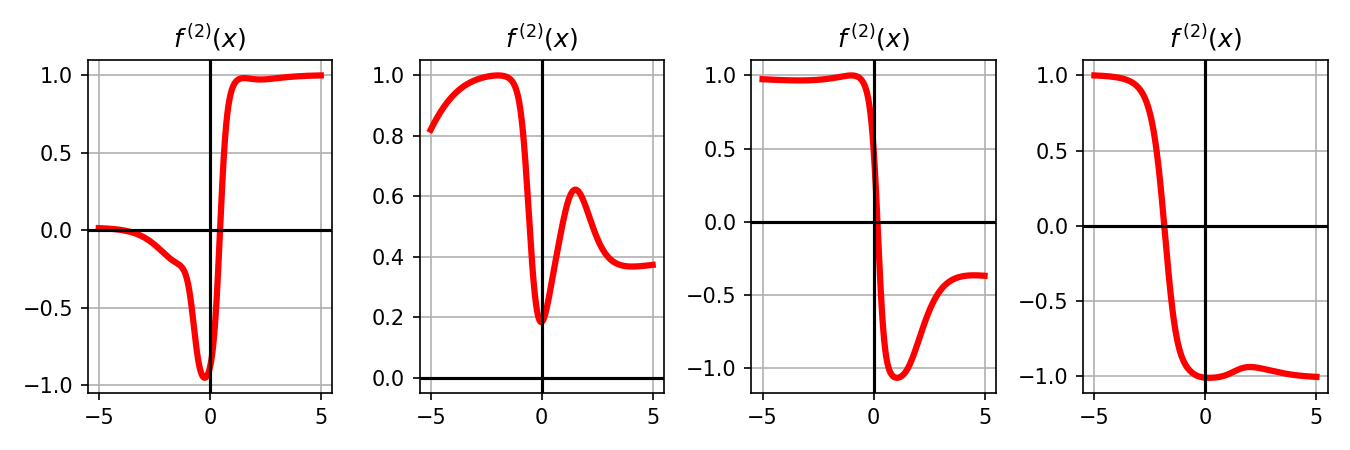

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 2, activation = 'tanh')

Below we show four exemplars of the same sort of unit - only now we use the ReLU activation instead of the $\text{tanh}$.

<IPython.core.display.Javascript object>


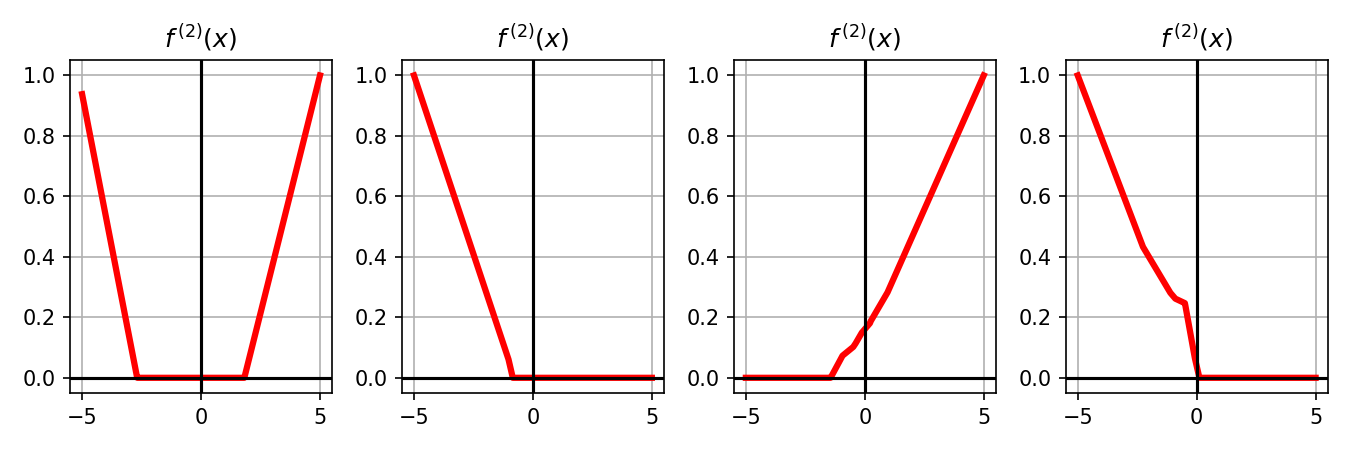

In [5]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 2, activation = 'relu')

---

In general if we wish to create a model using $B = U_2$ such two layer units we have

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f^{(2)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(2)}_{U_2}\left(\mathbf{x}\right)w_{U_2}.
\end{equation}

Here the parameter set $\Theta$ both those weights internal to the units as well as the final linear combination weights.

Notice in this case that each two layer unit now has its own unique internal parameters in the linear combination of single layer units (but the weights intnernal to the single layer units are the same for each two layer unit we define).  The $j^{th}$ of which looks like 

\begin{equation}
f^{\left(2\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(2\right)}_{0.j}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i,j}}\,f^{(1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

Figure 3 shows a graphical representation, or architecture, of a generic two-layer neural network model whose algebraic form is given in (16).  In the top panel we illustrate each input single layer unit precisely as shown in the bottom panel of Figure 1.  The input layer, all the way to the left, is first fed into each of our $U_1$ single layer units - which still constitutes the first *hidden layer* of the network since its computation is not immediately visible to us (unlike our training data).  Then *the same linear combination of these single layer units* is fed into each of our two layer units.  This second layer of unit computation is referred to by convention as the *second hidden layer*, since its computation is also not immediately 'visible' to us.  At last - all the way to the right of this panel - we see a linear combination of these $U_2$ produces which produces the final (visible) layer of the network, the output of our model.  In comparing the graphical and algebraic representations of a two layer model, notice that reading the graph from left to right corresponds to starting *internally* to the single layer units $f^{(1)}_j$, and working outwards to the second layer units, and then to the final linear combination.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/two_layer_network.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> (left panel) Graphical representation of a two-layer neural network model, given in Equation (16), which is composed of $U_2$ two-layer feature transformations of the form shown in Equation (17). (top right panel) A condensed graphical representation of a  two-layer neural network. (bottom right panel) This network can be represented more compactly via its computational graph. </em>
</figcaption>
</figure>

As with the single layer model here it is also helpful to compactify both our notation and the corresponding visualization of a two layer model in order to simplify our understanding and make the concept easier to weild.  Using the same notation introduced in the previous Subsection, we can compactly designate the output of our $U_1$ single layer units / first hidden layer as

\begin{equation}
\text{output of first hidden layer} \,\,\,\,\,\,\,\,\, \mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right).
\end{equation}

Then, following the same pattern here to compactly express our second layer units, we can condense all internal weights of our $U_2$ second layer units column-wise into a $\left(U_1 +1 \right)\times U_2$ of the form

\begin{equation}
\mathbf{W}_{2}=\left[\begin{array}{cccc}
w_{0,1}^{\left(2\right)} & w_{0,2}^{\left(2\right)} & \cdots & w_{0,U_{2}}^{\left(2\right)}\\
w_{1,1}^{\left(2\right)} & w_{1,2}^{\left(2\right)} & \cdots & w_{1,U_{2}}^{\left(2\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{U_1,1}^{\left(2\right)} & w_{U_1,2}^{\left(2\right)} & \cdots & w_{U_1,U_{2}}^{\left(2\right)}
\end{array}\right]
\end{equation}  

which mirrors precisely how we defined the $\left(N+1\right) \times U_1$ internal weight matrix $\mathbf{W}_1$ for our single layer units.

This allows us to likewise express the output of our two layer units / second hidden layer compactly as

\begin{equation}
\text{output of second hidden layer} \,\,\,\,\,\,\,\,\, \mathring{\mathbf{a}}\left(\mathbf{W}_2^T\mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)\right)
\end{equation}

and here the recursive nature of the two layer unit is on full display.  Remember that we use the notation $\mathring{\mathbf{a}}$ somewhat loosely as a function in the sense that it simply represents taking the nonlinear activation - elementwise - of whatever vector is input into it.  In the first layer this vector $\mathbf{W}_1^T\mathring{\mathbf{x}}$ has size $\left(U_1 + 1\right) \times 1$, in the second its input $\mathbf{W}_2^T \mathring{\mathbf{a}}$ has size $\left(U_2 + 1\right) \times 1$.

Finally we can then compactly express our generic two hidden-layer model compactly by denoting the final linear combination weights as

\begin{equation}
\mathbf{w}_{3} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_2}
\end{bmatrix}
\end{equation}

which allows us to write the full two layer model, a linear combination of the output from our second hidden layer, as 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_3^T\mathring{\mathbf{a}}\left(\mathbf{W}_2^T\mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)\right)
\end{equation}

As with its single layer analog, this compact algebraic depiction of a two layer network lends itself to much more easily digestible, and extended, visual depictions.  In the bottom left panel of the figure above show a slightly condensed version of the original graph in the top panel, where the reduandnacy of showing every single layer units reduced to a single visual representation.  The linear weights attached to the entire set of single layer units are shown here more compactly as the set of criss-crossing line segments connecting the input to each unit, with the matrix $\mathbf{W}_1$ jointly representing all $U_1$ of the weighted combinations.  The same visual depiction is given for the second hidden layer as well, where $\mathbf{W}_2$ is the corresponding set of weights for combining single layer units defined above.  Throughout the graph we reomve all function notations along the edge for better visibility, as we can tacitly assume these nonlinearities are present without cluttering the visualization.  In the bottom right panel we condense this two layer depiction even further into a *computation graph*.  Here the operations of the two layer model is depicted  with scalars, vectors, and matrices are depicted symbolically as circles, diamonds, and squares, respectively.  Tracking these compact graphical and algebraic representations of a two layer model, again reading either compact graph from left to right corresponds to analyzing the formula above *starting at the inner-most parenthesis* or composition (where the single layer computations are performed) and working outwards.

## General multi-layer perceptron units

By recursing on the pattern we have seen above in describing single and two layer perceptron units we can construct arbitrary *multi-layer perceptrons*, with each added hidden layer increasing the capacity of a multi-layer unit.  In the figure below we show the graphical representation of a general $L$ hidden-layer unit, or $L$ layer unit for short. To construct a network unit like this with an arbitrary number of layers we simply recurse on the pattern we have seen established above $L-1$ times - with the resulting $L$ hidden-layer unit taking as input a number $U_{L-1}$ of $L-1$ hidden-layer units.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/L_layer_unit.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 4:</strong> <em> Graphical representation of an $L$-layer neural network unit. </em>
</figcaption>
</figure>

The algebraic form of an $L$ layer unit shown in the Figure above $f^{\left(L\right)}\left(\mathbf{x}\right)$ is given by the formula 

\begin{equation}
f^{\left(L\right)}\left(\mathbf{x}\right)=a\left(w^{\left(L\right)}_{0}+\underset{i=1}{\overset{U_{L-1}}{\sum}}{w^{\left(L\right)}_{i}}\,f^{(L-1)}_i\left(\mathbf{x}\right)\right).
\end{equation}

which reflects the recursive nature of the $L$ layer unit algebraically.  As was the case with the two layer unit, this formula is perhaps easier to digest if we think about each step of the computation starting from the most internal (that is, the construction of the first layer units) to the final outer activation function.  We detail this way of expressing the generic $L$ layer unit algebraically in the 'recursive recipe' below. 

#### Recursive rescipe for $L$ layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of single $L-1$ layer units $U_{L-1}$<br>

<strong>2:</strong>&nbsp;&nbsp;  Construct $L-1$ layer units:  $\,\,\,\,\,\,\,\,\,f^{(L-1)}_i\left(\mathbf{x}\right)$ for $i=1,\,...,U_{L-1}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\, v = w_{0}^{(L)}+{\sum_{i=1}^{U_{L-1}}}{w_{i}^{(L)}\,f^{(L-1)}_i}\left(\mathbf{x}\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\,\, a\left(v\right)$ <br>

<strong>5:</strong>&nbsp;&nbsp; <strong>output:</strong> $L$ layer unit $\,\, a\left(v\right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 3. </span> Illustrating the capacity of three-layer units 

In this Example we show four instances of a three-layer perceptron unit with various activation functions.  A note on jargon: often a model composed of units that have three or more hidden layers is called a *deep network*.  Also note that while in principle the same activation function need not be used for all layers of an $L$ hidden-layer unit, for the sake of simplicity a single kind of activation is almost always used.

First we show off several instances of a three layer unit with $\text{tanh}$ activation.  The greater variety of shapes shown - as compared to two and single layer analogs shown in prior Examples - reflects the increased capacity of these units.

<IPython.core.display.Javascript object>


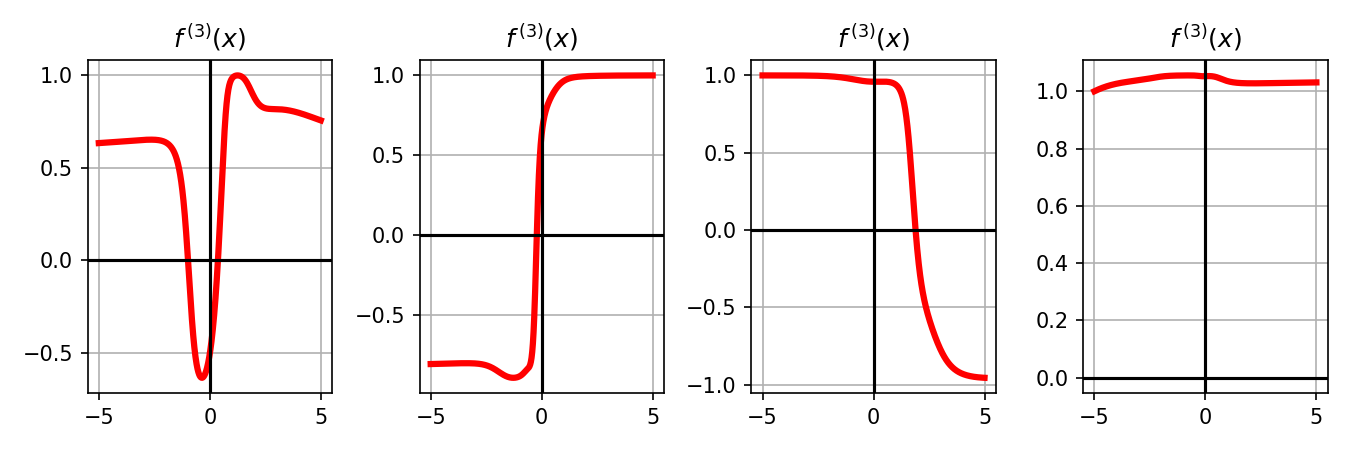

In [6]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 3, activation = 'tanh')

Below we repeat the same experiment, only using the ReLU activation function instead of $\text{tanh}$.

<IPython.core.display.Javascript object>


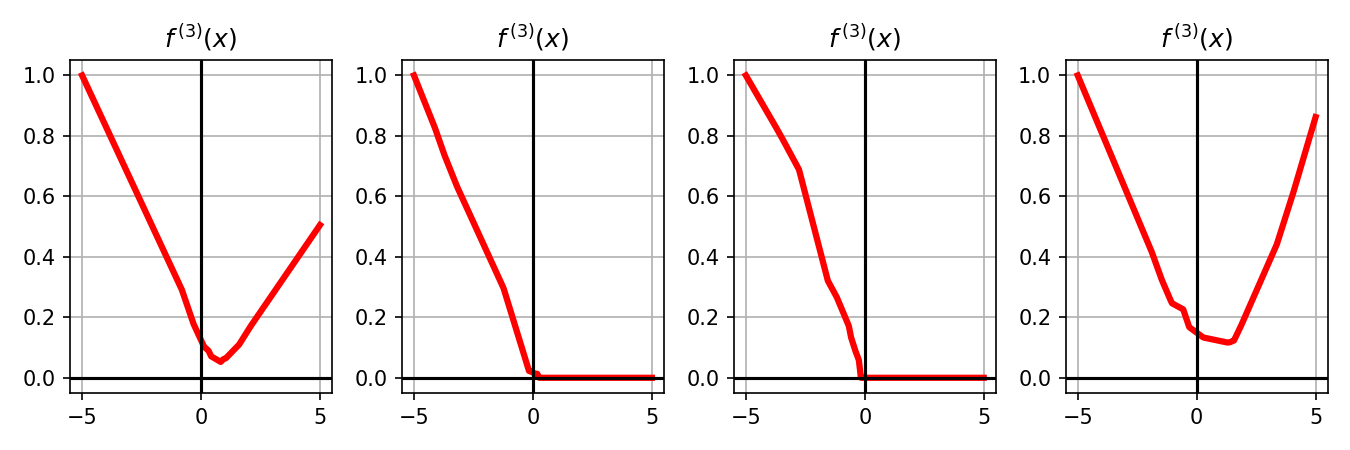

In [7]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 3, activation = 'relu')

---

In general we can produce a model consisting of $B = U_L$ such $L$ layer units  

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f^{(L)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(L)}_{U_L}\left(\mathbf{x}\right)w_{U_L}
\end{equation}

where parameter set $\Theta$ both those weights internal to the units as well as the final linear combination weights.  The $j^{th}$ unit takes the familiar form

\begin{equation}
f^{\left(L\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(L\right)}_{0.j}+\underset{i=1}{\overset{U_{L-1}}{\sum}}{w^{\left(L\right)}_{i,j}}\,f^{(L-1)}_i\left(\mathbf{x}\right)\right).
\end{equation}

Figure below shows a unraveled graphical representation of this model, or architecture, that is a direct generalization of the kinds of visualizations we have seen previously. From left to right we can see the input layer to the network, its *$L$ hidden layers*, and the final output layer (the output of the model).

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/L_layer_network_unfolded.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> Graphical representation of an $L$-layer neural network model, given in Equation (26), which is composed of $U_L$ $L$-layer feature transformations of the form shown in Equation (27). </em>
</figcaption>
</figure>

To simplify our understanding of this general network architecture we can use precisely the same compact notation and visualizations we have introduced in the simpler context of single and two layer networks.  In complete analogy to the way we compactly represented two layer networks above, we can denote the output of the $\left(L\right)^{th}$ layer compactly as

\begin{equation}
\text{output of $\left(L\right)^{th}$ hidden layer} \,\,\,\,\,\,\,\,\, \mathring{\mathbf{a}}\left(\mathbf{W}_{L}^T\,\mathring{\mathbf{a}}\left(  \mathbf{W}_{L-1}^T \mathring{\mathbf{a}}\left( \cdots \mathbf{W}_{1}^T\mathring{\mathbf{x}}\right)\cdots\right)\right)
\end{equation}

which displays rather compactly the recursive nature of the final hidden layer's output.  Here - as we found previously - the dimensions of the first two layer weight matrices $\mathbf{W}_1$ and $\mathbf{W}_2$ are is $\left(N + 1\right) \times U_1$ and $\left(U_1 + 1\right) \times \left(U_2 + 1\right)$, respectively.  By the same logic the dimensions of the $l^{th}$ such matrix $\mathbf{W}_l$ is $\left(U_{l-1} + 1\right) \times U_l$. 

Denoting the weights of the final linear combination as

\begin{equation}
\mathbf{w}_{L+1} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_L}
\end{bmatrix}
\end{equation}

we can express the model of $L$ layer units compactly as 


\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_{L+1}^T\mathring{\mathbf{a}}\left(\mathbf{W}_{L}^T\,\mathring{\mathbf{a}}\left(  \mathbf{W}_{L-1}^T \mathring{\mathbf{a}}\left( \cdots \mathbf{W}_{1}^T\mathring{\mathbf{x}}\right)\cdots\right)\right)
\end{equation}

In Figure below we show a graphical representation of an $L$-layer network (top panel) along with its computational graph (bottom panel) employing once again our condensed notation described above.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/L_layer_network_compact.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> (top panel) Graphical representation of an $L$-layer neural network.  (bottom panel) A computational graph of a generic $L$ layer network. </em>
</figcaption>
</figure>

This compact algebraic depiction of a an arbitrary $L$ layer network lends itself to much more easily digestible, and extended, visual depictions.  The middle panel of the figure above shows a condensed version of the original graph in the top panel, where the reduandnacy of showing every $L-1$ layer unit is reduced to a single visualization.  The computation in each layer is now represented visually as the set of criss-crossing edges connecting each subsquent set of layers, each weighted by their respective weight matrix.  The bottom *computation graph* represents the network architecture even more compactly, with the operations of the $L$ layer model depicted densely with scalars, vectors, and matrices are shown symbolically as circles, diamonds, and squares, respectively.  Tracking these compact graphical and algebraic representations from left to right corresponds to analyzing the formula above *starting at the inner-most parenthesis* or composition (where the single layer computations are performed) and working outwards.

## Selecting proper network architectures

We have now seen a general and recursive method of constructing arbitrarily deep multi-layer perceptrons, but many curiosities and technical issues need be addressed, and are the subject of subsequent Sections of this Chapter.  These include the choice of activation function, popular cross-validation methods for models employing network units, a variety of issues to discuss regarding optimization including the notion of *batch normalization*, and the notion of *backpropogation*. However one fundamental question can - at least in general - be addressed now, which is (the question of) how in general we choose the number of units and layers for a network architecture.  As with the choice of proper universal approximator in general (as detailed in Chapter 11), typically we do not know apriori what sort of network architecture (i.e., how many units, hidden layers, nor the shape of each hidden layer) will work best for a given dataset ahead of time.  In order to determine the best architecture for use with a given dataset we must - in general - cross-validate an array of choices. In doing so it must be kept in mind that, generally speaking, the capacity gained by adding new individual units to a network is much smaller relative to the capacity gained by addition of new hidden layers (see Figure below).

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/unit_vs_layer.png" width="90%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> The capacity gained by adding new layers to a neural network (left) is larger relative to the capacity gained by addition of new individual units to an existing layer (right). </em>
</figcaption>
</figure>

##  Biological model of a single hidden-layer unit

 A biological neuron is a single cell, of which there are roughly $10^{11}$ inside the human brain, and work in concert when human beings perform cognitive tasks.  Even when performing minor tasks human beings employ a sizable series of interconnected neurons - called biological *neural networks* - to perform the task properly.  For example somewhere between $10^{5}$ to $10^{6}$ neurons are required to render a realistic image of our visual surroundings [[4]](#bib_cell).  Most of the basic jargon and modeling principles of neural network universal approximators we have seen in this Section originated as a (very) rough mathematical model of such biological neural networks. 

An individual biological neuron (shown in the left panel below) consists of three main parts: *dendrites* (the neuron's receivers), *soma* (the cell body), and *axon* (the neuron's transmitter).  Starting around the 1940s [[1,2]](#bib_cell) psychologists and neuroscientists, with a shared desire to understand the human brain better, became interested in modeling neurons mathemtaically.  These early models - later dubbed as artificial neurons (a basic exemplar of which is shown in the right panel below) - culminated in the introduction of the *perceptron* model [[3]](#bib_cell) in 1957.  Closely mimicking this structure, an artificial neuron comprises a set of dendrite-like edges that connect it to other neurons, each taking an input and multiplying it by a (synaptic) weight associated with that edge.  These weighted inputs are summed up after going through a *summation unit* (shown in the panel by a small hollow circle). The result is subsequently fed to an *activation unit* (shown by a large blue circle) whose output is then transmitted to the outside via an axon-like projection.  From a biological perspective, neurons are believed to remain inactive until the net input to the cell body (soma) reaches a certain threshold, at which point the neuron gets *activated* and fires an electro-chemical signal, hence the name *activation function*.

This simple 'artifical neuron' is precisely an example of a *single hidden layer neural network unit*.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/bio_v_art.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> (left) A typical biological neuron. (right) An artificial neuron (also called a perceptron). An artificial neuron is a simplistic mathematical model for the biological neuron consisting of: (i) weighted edges that represent the individual multiplications (of $1$ by $w_{0}$, $x_1$ by $w_{1}$, etc.), (ii) a summation unit shown as a small hollow circle representing the sum $w_0+w_{1}\, x_1+\cdots+w_{N}\, x_N$, and (iii) an activation unit shown as a larger blue circle representing the sum evaluated by the nonlinear activation function $a$.  This simple 'artifical neuron' is precisely an example of a *single hidden layer neural network unit*.</em>
</figcaption>
</figure>

Stringing together large sets of these artificial neruons in layers creates a more mathematically complex model of a biological neural network, which still remains a very simple approximation to the human brain.  The figure below contains the kind of graphical representation (here of a two layer network) used when thinking about neural networks from this biological perspective.  In this rather complicated visual depiction every multiplicative operation of the architecture is shown as an edge, creating a complex mesh of intersecting lines connecting each layer.  In deriving neural network architectures above we preferred simpler more compact visualizations that avoid this sort of complex visual mesh.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/2_layer_neural_network.png" width="80%" height="auto"/>
<figcaption> <strong>Figure 4:</strong> <em> An example of a two layer network as commonly illustrated when detailing neural newtorks from a biological perspective.  The complex mesh of edges makes this sort of visualization rather difficult to interpret. </em>
</figcaption>
</figure>

##  Efficient Python implementation of multi-layer perceptrons

Now we can construct a model consisting of $L$ layer network units very efficiently as function written in Python and (`autograd` wrapped) `numpy`.  As with the examples and implementations given throughout Chapter 10, here we break the implementation of this model into a *feature transformation* function and the final model.  

Here our feature transformation function `feature_transforms` takes in the input $\mathbf{x}$, written as the variable `a`, and  entire set of internal weight matrices $\mathbf{W}_1$ through $\mathbf{W}_L$ of our network architecture written as the variable `w` where `w = [W_1,W_2,W_3,...,W_L]`.  This list of weight matrices is often referred to as a *tensor* in practice.  The output of our feature transformation function is the output of the final layer of the network, expressed algebraically in equation (24).  We compute this output we recursively *starting with the inner-most paranethesis* of this formula, looping *forward through the network architecture* starting with the first hidden layer using matrix $\mathbf{W}_1$ and ending with the computation of the final hidden layer using $\mathbf{W}_L$.  This results in a Python function cnosisting of a simple for loop.  Note: here `activation` can refer to any elementary function built using `numpy` operations.  For example, the simple $\text{tanh}$ activation can be written as `np.tanh(a)`, and the ReLU as `np.maximum(0,a)`.

In [8]:
# a feature_transforms function for computing
# U_L L layer perceptron units efficiently
def feature_transforms(a, w):    
    # loop through each layer matrix
    for W in w:
        # compute inner product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])

        # output of layer activation
        a = activation(a).T
    return a

With our feature transforamtions function complete we can use precisely the same sort of `model` implementation we employed in earlier Chapters, which we repeat below for convenience.  Taken together these two Pythonic functions implement the general $L$ layer network model shown in equation (25).  Here our inputs to this Python function are `x` - our input data - and a list of length two whose first entry contains our tensor of internal network weights of weights and whose second entry contains the weights of the final linear combination.

In [9]:
# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # compute linear combination and return
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

Finally, we also provide a Python function called ``initialize_network_weights`` that creates initial weights for the general network model, and also provides a simple interface for creating general architectures since it is this initializer that determines the shape of the network.  To create a desired network you simply input a **comma-separated list** called ``layer_sizes`` into the function of the following form

\begin{equation}
\text{layer_sizes} = \begin{bmatrix}
N = \text{dimension of input }\mathbf{x} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \\
U_1 = \text{number of desired units in layer 1} \\
U_2 = \text{number of desired units in layer 2} \\
\vdots \\
U_L = \text{number of desired units in layer L} \\
M = \text{dimension of output } y \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\end{bmatrix}
\end{equation}

The initializer will then automatically create initial weight matrices (of the proper dimensions) $\mathbf{W}_1$ through $\mathbf{W}_L$ as well as the final weights for the linear combination in the prediction $\mathbf{w}$.  We will see explicit examples using this functionality - as well as the previous Python functions - in the examples below.

In [10]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes, scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k+1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

Below we provide several examples using this implementation.

#### <span style="color:#a50e3e;">Example 4. </span>  Nonlinear two-class classification example using multilayer perceptrons

Here we use a network architecture to perform nonlinear classification using a toy dataset shown in the previous Chapter.  Here we arbitrarily choose the network architecture with 4 hidden layers with 10 units in each layer, a $\text{tanh}$ activation, and a Softmax cost function.  Below we visualize the fit provided by the final weights learned via gradient descent. 

<IPython.core.display.Javascript object>


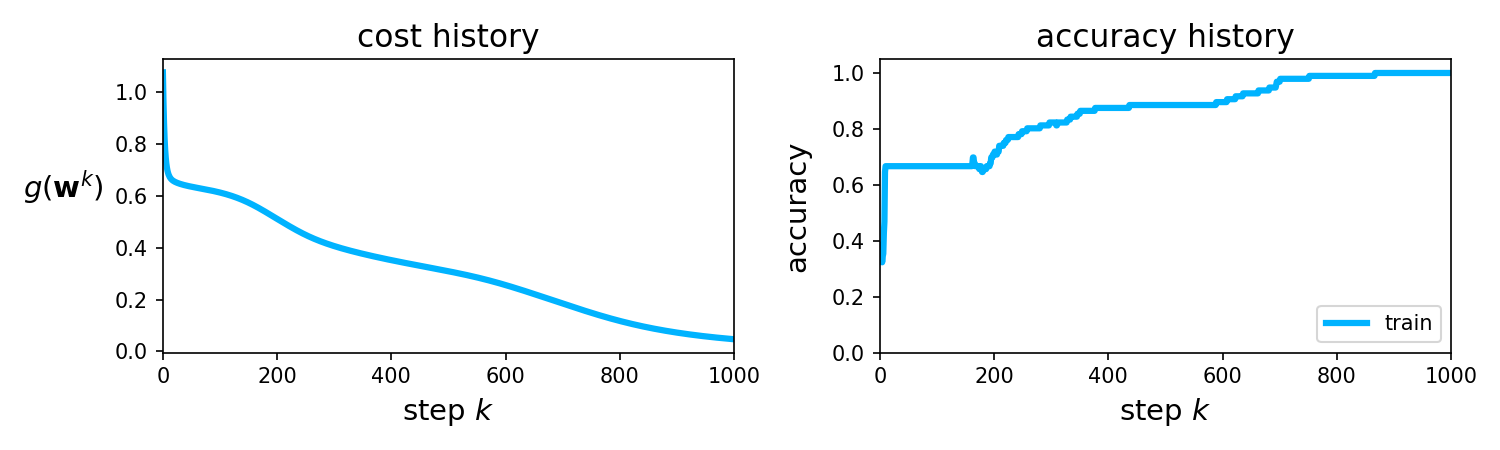

<IPython.core.display.Javascript object>


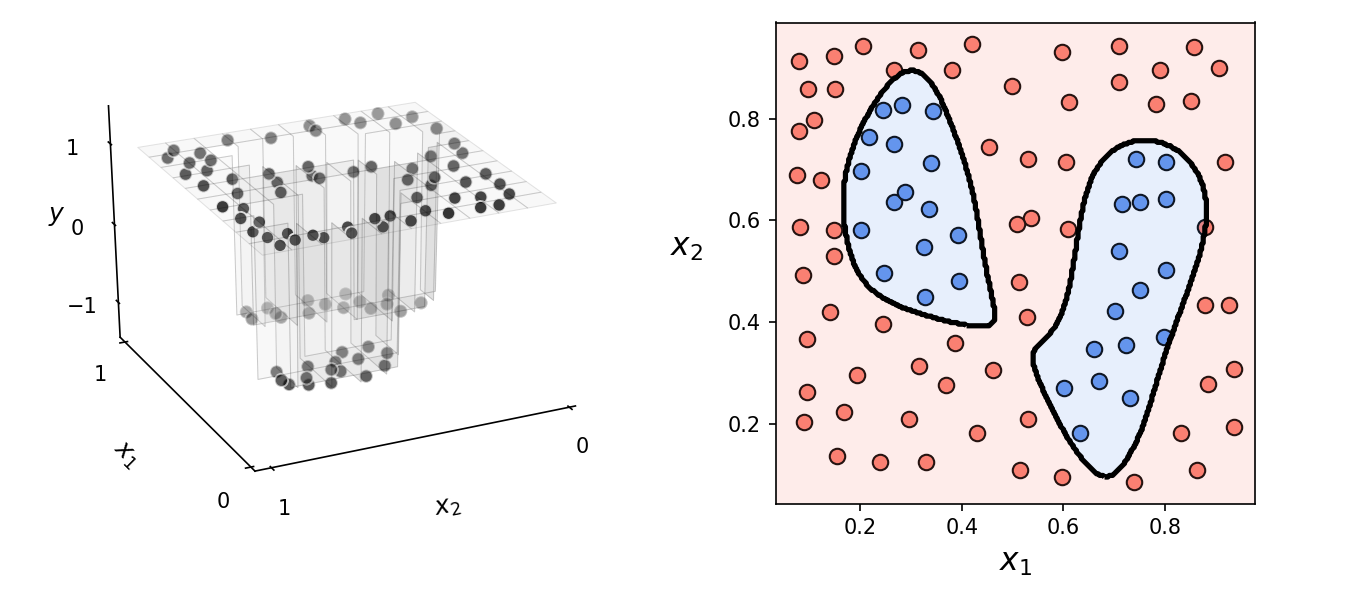

In [11]:
# This code cell will not be shown in the HTML version of this notebook
# create instance of linear regression demo, used below and in the next examples
demo5 = multi.nonlinear_classification_visualizer.Visualizer(datapath + '2_eggs.csv')
x = demo5.x.T
y = demo5.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
# demo5.plot_data();

# An example 4 hidden layer network, with 10 units in each layer
N = 2  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w = initialize_network_weights(layer_sizes, scale = 0.5)

# initialize with input/output data
mylib5 = multi.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib5.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib5.make_train_val_split(train_portion = 1)

# choose cost
mylib5.choose_cost(name = 'softmax')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10,10,10]
mylib5.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh',scale = 0.5)

# fit an optimization
mylib5.fit(max_its = 1000,alpha_choice = 10**(-1),verbose = False)

# plot cost function history
mylib5.show_histories()


# illustrate results
ind = np.argmax(mylib5.train_accuracy_histories[0])
w_best = mylib5.weight_histories[0][ind]
demo5.static_N2_simple(w_best,mylib5,view = [30,155])

#### <span style="color:#a50e3e;">Example 5. </span> Nonlinear multiclass classification using two layer units

In this example we perform multi-class classification on a $C=3$ class classification dataset using a model consisting of two layer units, the $\text{tanh}$ activation (and share them across all classifiers - as detailed in Section 10.4.2), and the Multiclass Softmax cost.  Here we arbitrarily choose the number of units in each layer as $U_1 = 12$ and $U_2 = 5$ respectively.  Below we plot the resulting decision boundary found by minimizing the cost via gradient descent.

<IPython.core.display.Javascript object>


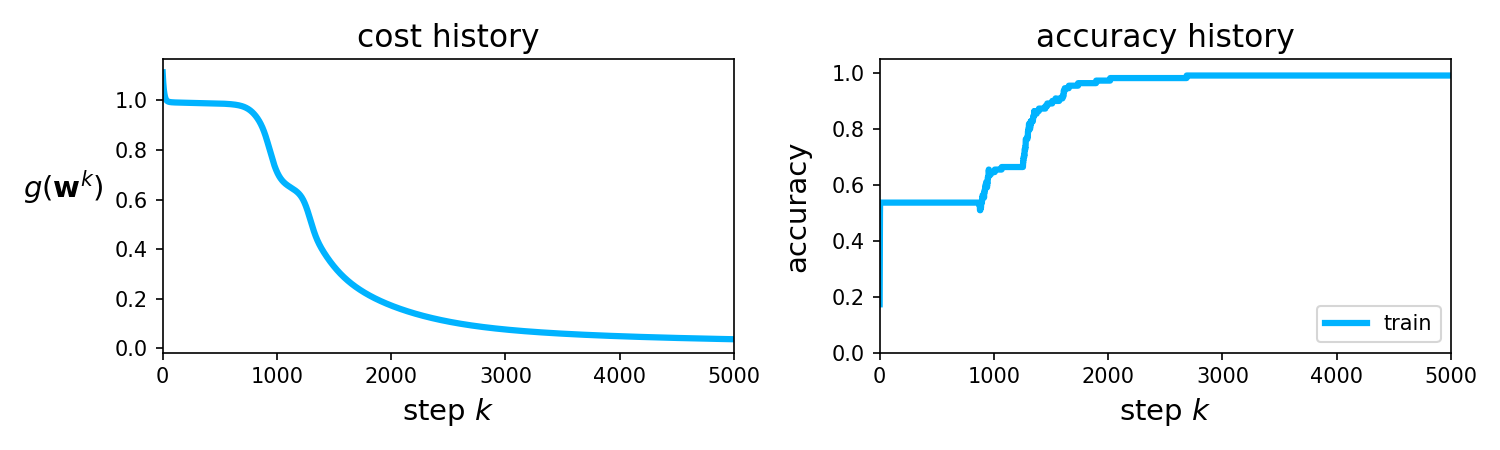

<IPython.core.display.Javascript object>


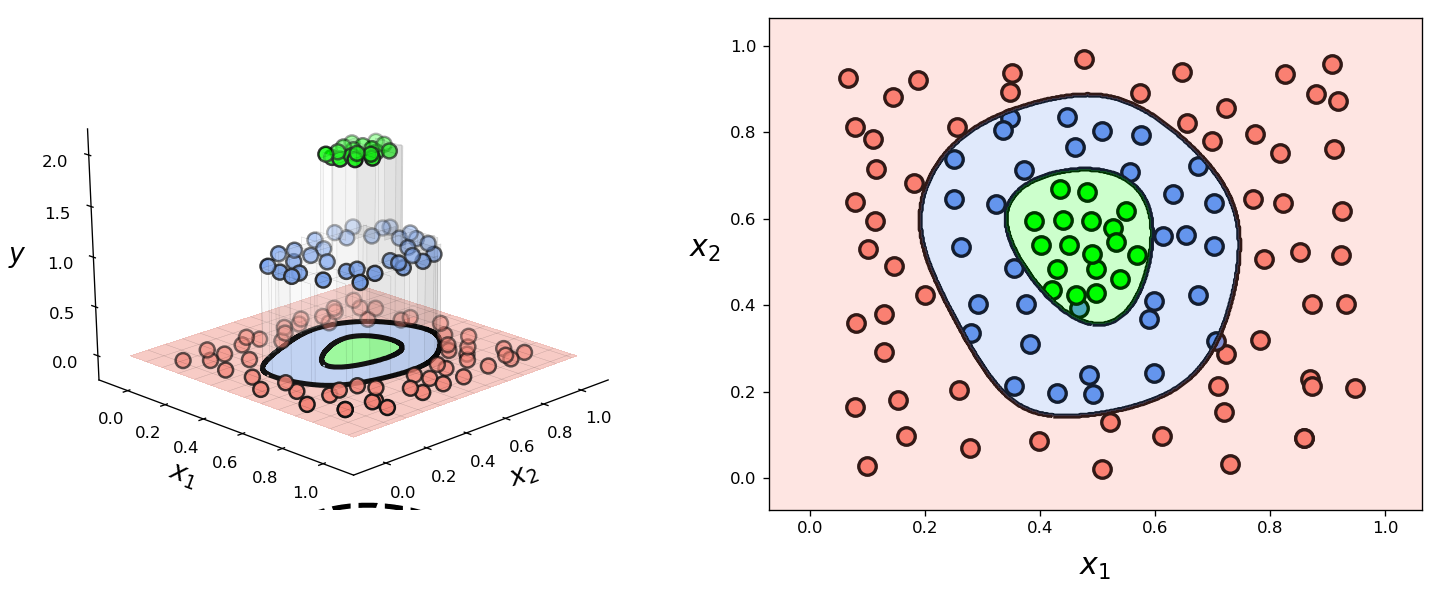

In [12]:
# This code cell will not be shown in the HTML version of this notebook
# create an instance of a multiclass classification visualizer
demo3 = multi.nonlinear_classification_visualizer.Visualizer(datapath + '3_layercake_data.csv')
x = demo3.x.T
y = demo3.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
# demo3.plot_data();

# define the number fo units to use in each layer
N = 2         # dimension of input
U_1 = 12      # number of single layer units to employ
U_2 = 5       # number of two layer units to employ

# initialize internal weights of our single layer units
W_1 = 0.1*np.random.randn(N+1,U_1)

# initialize internal weights of our second layer units
W_2 = 0.1*np.random.randn(U_1+1,U_2)

# initialize weights of our linear combination
w_3 = 0.1*np.random.randn(U_2+1,3)

# package all weights together in a single list
w = [W_1,W_2,w_3]

# initialize with input/output data
mylib3 = multi.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib3.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib3.make_train_val_split(train_portion = 1)

# choose cost
mylib3.choose_cost(name = 'multiclass_softmax')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [12,5]
mylib3.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh',scale = 0.1)

# fit an optimization
mylib3.fit(max_its = 5000,alpha_choice = 10**(-1),verbose = False)

# plot cost function history
mylib3.show_histories()

# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmax(mylib3.train_accuracy_histories[0])
w_best = mylib3.weight_histories[0][ind]

# plot result of nonlinear multiclass classification
demo3.multiclass_plot(mylib3,w_best)

#### <span style="color:#a50e3e;">Example 7. </span>  Learning a nonlinear manifold using multilayer perceptron encoding/decoding functions

In this example we illustrate the use of multilayer perceptrons for both the `encoder` $f_{\text{e}}$ and `decoder` $f_{\text{d}}$ a general autoencoder function (see e.g., Section 12.3 for an introduction to the nonlinear autoencoder).  Here for both functions we will arbitrarily use a 3 layer multilayer perceptron with 10 units in each layer and the `tanh` activation.  We will then tune the parameters of both functions by minimizing the autoencoder cost function to uncover the proper nonlinear manifold on which the following dataset sits.

<IPython.core.display.Javascript object>


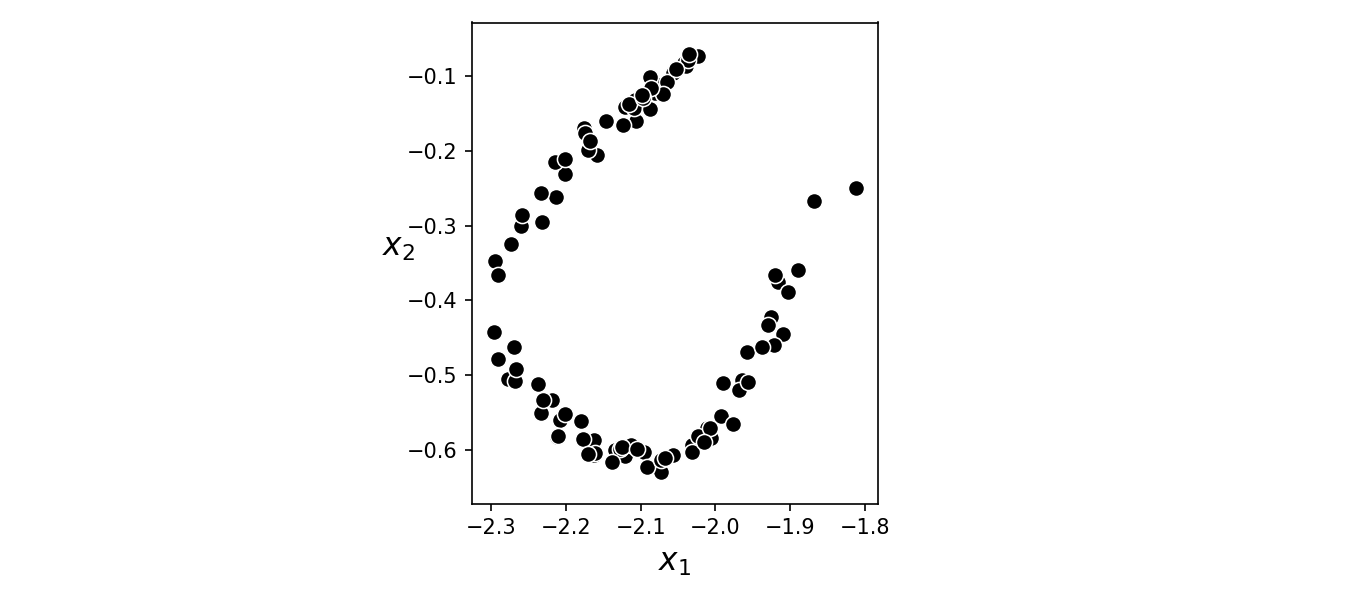

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# import data
X = np.loadtxt(datapath + 'universal_autoencoder_samples.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

<IPython.core.display.Javascript object>


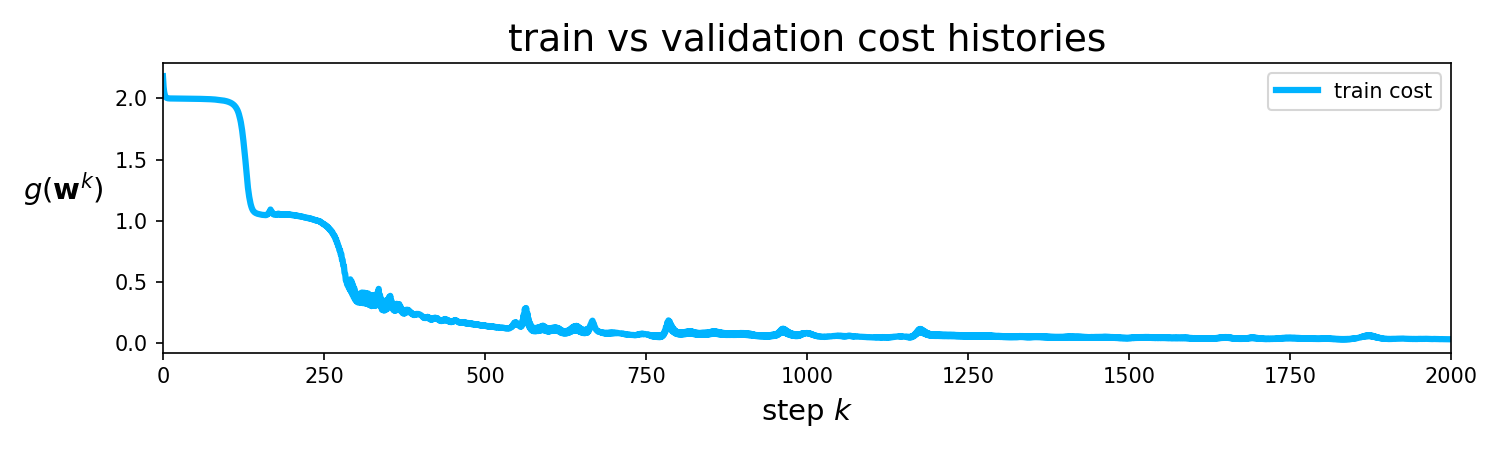

In [14]:
# This code cell will not be shown in the HTML version of this notebook
### initialize encoder network ###
N = 2  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_encoder = initialize_network_weights(layer_sizes, scale = 0.5)

### initialize decoder network ###
N = 1  # dimension of input
M = 2  # dimension of output

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_decoder = initialize_network_weights(layer_sizes, scale = 0.5)

# gather initializations for both encoder and encoder, package into single list
w = [w_encoder,w_decoder]

# create instance of library
mylib6 = multi.basic_lib.unsuper_setup.Setup(X)

# perform preprocessing step(s) - especially input normalization
mylib6.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib6.make_train_val_split(train_portion = 1)

# choose features
mylib6.choose_encoder(layer_sizes = [2,10,10,1],scale = 0.2)
mylib6.choose_decoder(layer_sizes = [1,10,10,2],scale = 0.2)

# choose cost
mylib6.choose_cost(name = 'autoencoder')

# fit an optimization
mylib6.fit(max_its = 2000,alpha_choice = 10**(-1),verbose = False)

# plot cost function history
mylib6.show_histories()

Having minimized the cost function appropriately using gradient descent we can now visualize the learned manifold (middle panel below) and the decoded version of the original dataset (right panel below) - i.e., the original dataset projected onto our learned manifold.  We can also visualize how all of the data in this space is projected onto the learned manifold via a vector field plot, which we do in the bottom panel.

<IPython.core.display.Javascript object>


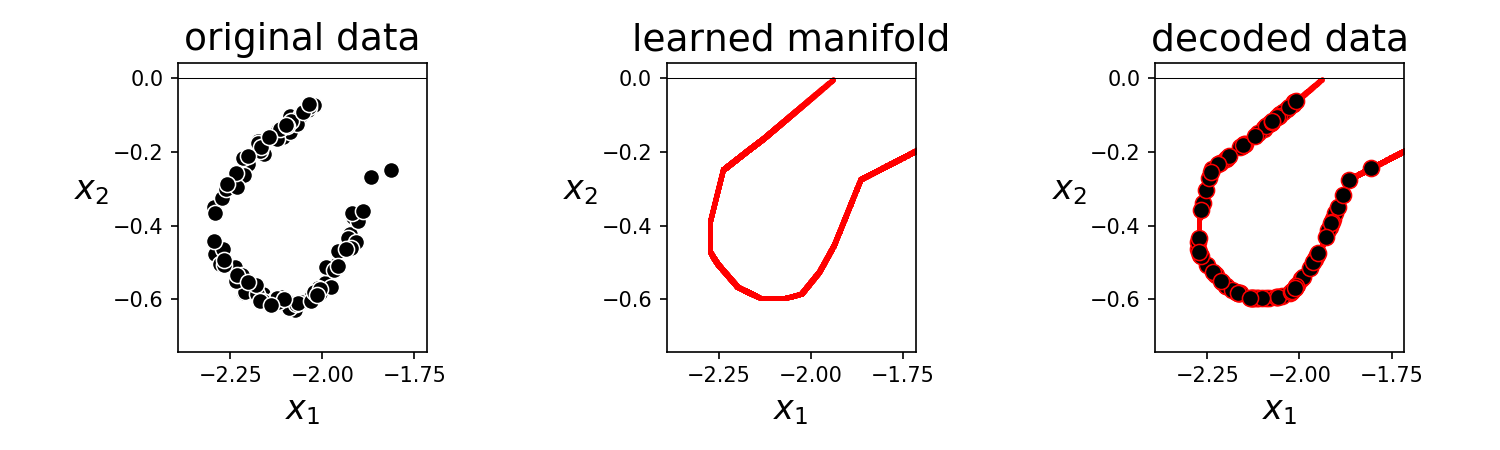

<IPython.core.display.Javascript object>


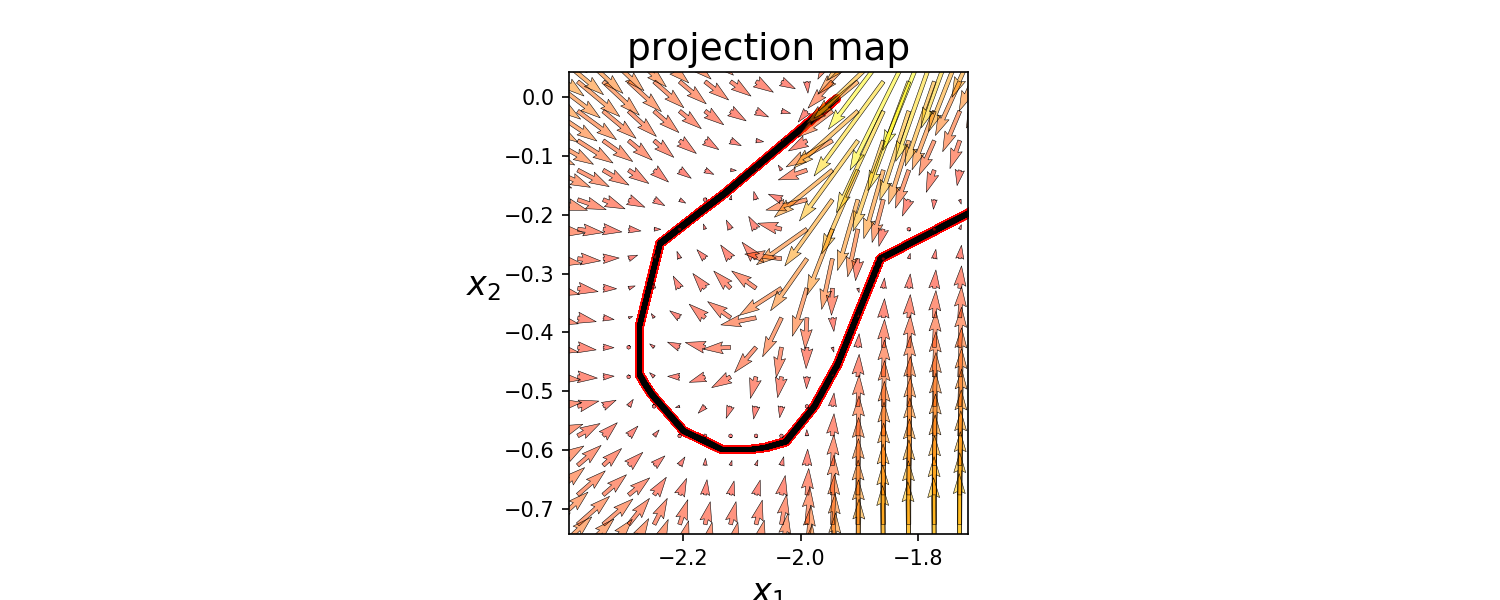

In [15]:
# This code cell will not be shown in the HTML version of this notebook
# plot results
multi.autoencoder_demos.show_encode_decode(X,mylib6,projmap = True,scale = 4.5)

#### <span style="color:#a50e3e;">Example 8. </span> The shape of random autoencoder functions employing a 5 layer multilayer perceptron for both encoder and decoder 

In Section 12.3 we introduced the general nonlinear autoencoder, which consists of two (in general) nonlinear functions - an `encoder` $f_{\text{e}}$ and `decoder` $f_{\text{d}}$ - whose parameters we tune so that (ideally) the composition $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ forms the best *nonlinear manifold* on which the input data sits.  That is, given a set of input points $\left\{\mathbf{x}_p\right\}_{p=1}^P$ we aim tune the parameters of our encoder / decoder pair so that ideally

\begin{equation}
f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) \approx \mathbf{x}_p
\end{equation}
 
for all of the datapoints.  Just as with a supervised learner we can use a multilayer perceptron here - and for both encoding and decoding functions - which in combination provides us with an enormous amount of flexibility in terms of the sort of nonlinear manifolds we can uncover.  

Below we plot out 9 random instances of an antoencoder function $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ where we have arbitrarily used a 5 hidden layer multilayer perceptron with 10 units in each layer for both functions, and the function `sinc` as an activation.  In other words, below is plotted 9 instances of the function $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ where both $f_{\text{d}}$ and $f_{\text{e}}$ are 5 layer networks with randomly chosen weights in each instance.  Each of examples shows the kind of nonlinear manifold we could potentially discover using such encoding/decoding functions.

<IPython.core.display.Javascript object>


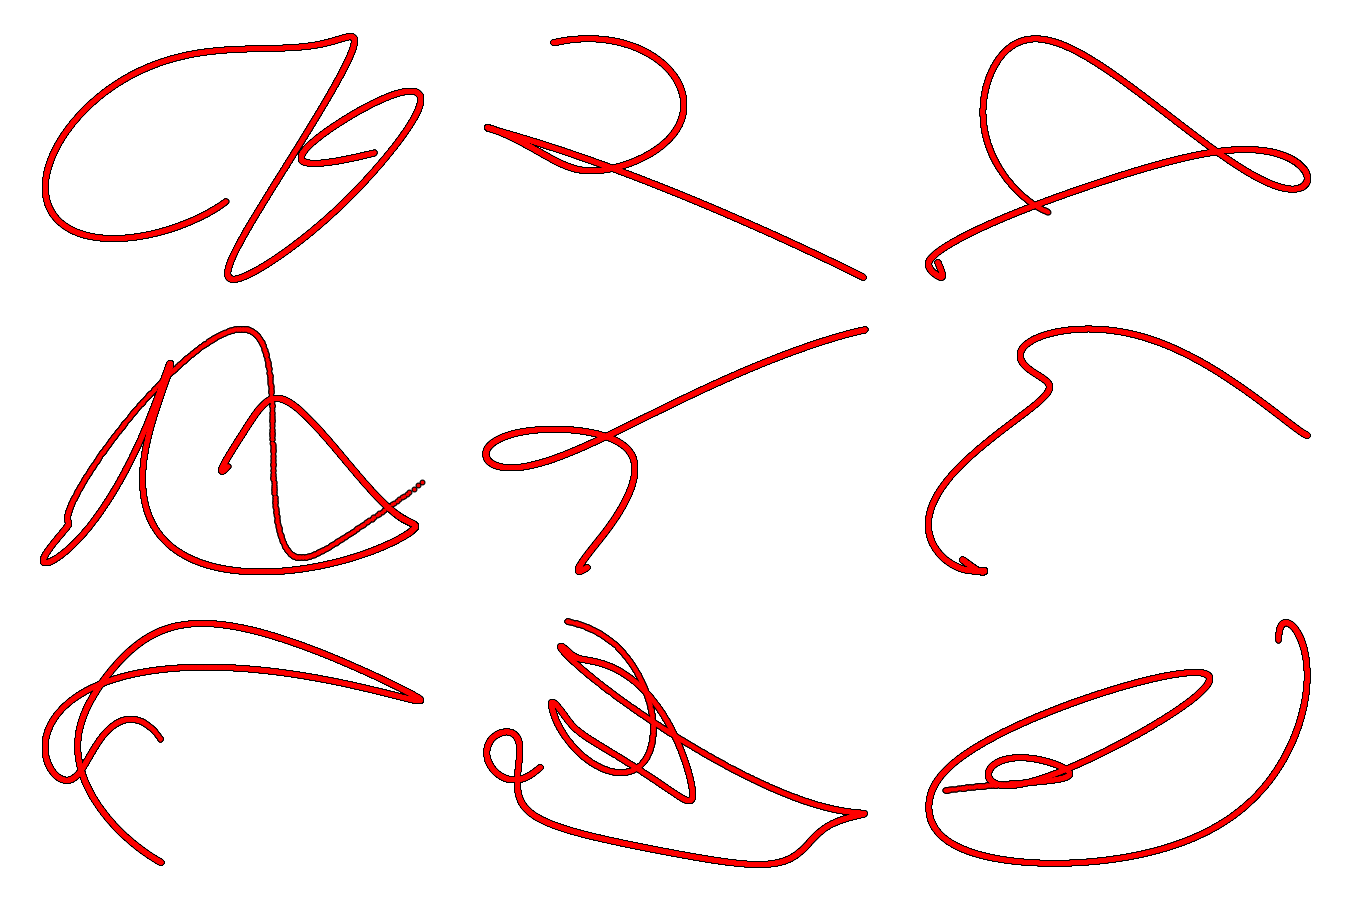

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# show off 9 random autoencoders built using a 5 layer network for both
# encoder and decoder function and sinc as an activation function
demo = nonlib.squiggle_generator.Setup()
demo.make_so_many_squiggles()

<a id='bib_cell'></a>

## References

[1]  W. S. McCulloch and W. Pitts. A logical calculus of the ideas immanent in nervous activity. The bulletin of mathematical biophysics, 5(4):115–133, 1943.

[2]  D. O. Hebb. The organization of behavior: a neuropsychological theory. John Wiley & Sons, New York, 1949.

[3]  F. Rosenblatt. The perceptron - a perceiving and recognizing automaton. Cornell Aeronautical Laboratory, 1957.